In [1]:
import sys
sys.path.append('./survival_utils')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%load_ext autoreload
%autoreload 2

DAYS_IN_YEAR = 365.25
from Survival_Analysis import Survival_Analysis
from nfhes_data_prep import prepare_nhfes_survival_data

# Load and preprocess NHFES data

Data available for download [here](https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/1268/20/nhefs.csv)

In [3]:
data_path = './data/nhefs.csv'
nhefs_all = prepare_nhfes_survival_data(data_path)
nhefs_all.head(2)

Optimization terminated successfully.
         Current function value: 0.542264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.542264
         Iterations 6


,pid,seqn,qsmk,death,yrdth,modth,dadth,sbp,dbp,sex,...,edu_5,exercise_0,exercise_1,exercise_2,active_0,active_1,active_2,pscore,IPW,OW
0,0,233,0,0,NaN,NaN,NaN,175.0,96.0,0,...,0,0,0,1,1,0,0,0.108998,0.827453,0.108998
1,1,235,0,0,NaN,NaN,NaN,123.0,80.0,0,...,0,1,0,0,1,0,0,0.148886,0.866232,0.148886


# Definitions for notebook

In [4]:
months_bins=1
pscore_col = 'pscore'
weights_col = ['IPW', 'OW']
id_col = 'seqn'
index_time_col = 'index_date'
outcome_time_col = 'date_death'
outcome_event_col = 'death'
TX_col = 'qsmk'
TX_labels_dict = {0:'Did not quit smoking', 1:'Quit smoking'}
TX_colors = {0:'royalblue', 1:'darkorange'}

followup_end_time = -int(7*DAYS_IN_YEAR) + 1
followup_max_time_from_index = int(10*DAYS_IN_YEAR) + 1
followup_max_time_from_index_binned = int(10*(12/months_bins)) + 1

ps_cols = ['one', 'sex', 'race', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 'exercise_1', 'exercise_2', 'active_1', 'active_2',
            'age', 'age_sqr', 'wt71', 'wt71_sqr','smokeintensity', 'smokeintensity_sqr', 'smokeyrs', 'smokeyrs_sqr']

nhefs_all[index_time_col] = -(17*DAYS_IN_YEAR)
nhefs_all[outcome_time_col] = ((nhefs_all['yrdth']-100)*DAYS_IN_YEAR + nhefs_all['modth']*(DAYS_IN_YEAR/12))
nhefs_all[outcome_time_col] = nhefs_all[outcome_time_col].fillna(followup_max_time_from_index)
data = nhefs_all.dropna(subset=['qsmk'])[ps_cols + weights_col + [index_time_col, outcome_time_col, outcome_event_col, 
                                                    pscore_col, TX_col, id_col]].copy()
data['censoring'] = followup_end_time
data.head(2)

,one,sex,race,edu_2,edu_3,edu_4,edu_5,exercise_1,exercise_2,active_1,...,smokeyrs_sqr,IPW,OW,index_date,date_death,death,pscore,qsmk,seqn,censoring
0,1,0,1,0,0,0,0,0,1,0,...,841,0.827453,0.108998,-6209.25,3653.0,0,0.108998,0,233,-2555
1,1,0,0,1,0,0,0,0,0,0,...,576,0.866232,0.148886,-6209.25,3653.0,0,0.148886,0,235,-2555


# Define survival, propensity and outcome data frames

In [5]:
data_df = data.drop([pscore_col, outcome_event_col, outcome_time_col] + weights_col, axis=1)
ps_df = data[[id_col, pscore_col] + weights_col + ps_cols]
outcome_df = data[[id_col, outcome_event_col, outcome_time_col, 'censoring']]

# Survival analysis - outcome: death, treatment: qsmk (quite smoking)

## Initialize class

To save the outputs of the class provide a path in the *output_dir* parameter

In [7]:
survival_analysis = Survival_Analysis(data_df, outcome_df, outcome_time_col, 'censoring', 'Death', 
                                      id_col, index_time_col, TX_col, TX_labels_dict, TX_colors, followup_end_time, 
                                      followup_max_time_from_index, months_bins, ps_df, 'pscore', ps_cols, 'IPW', n_bootstraps=5)

## Fit and plot Logistic Reregression model, unweighted

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.79s/it]


Difference in survival probability at time 120: 4.703% (2.354, 9.183)
 Incident rate: Did not quit smoking: 216, Quit smoking: 102
Odds ratio at max followup: 0.359 (0.219, 0.431)


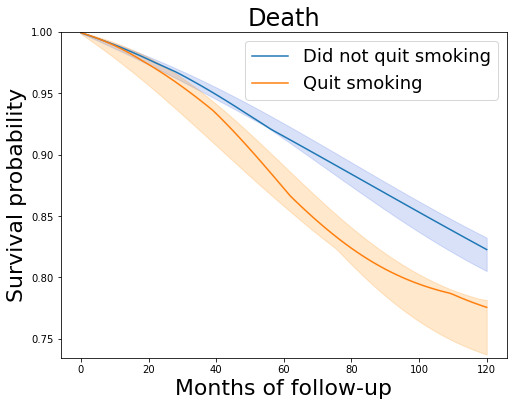

In [8]:
survival_analysis.estimate_survival(method='LR')
survival_analysis.plot_survival()
survival_analysis.survival_difference(followup_max_time_from_index_binned - 1)
survival_analysis.odds_ratio_at_max_follwup()

## Fit and plot Logistic Reregression model, weighted using Inverse Probability Weighting

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.69s/it]


Difference in survival probability at time 120: 0.501% (-2.118, 3.512)
 Incident rate: Did not quit smoking: 216, Quit smoking: 102
Odds ratio at max followup: 0.425 (0.023, 0.572)


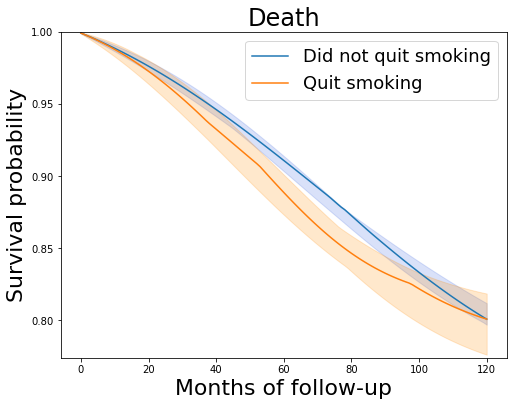

In [9]:
survival_analysis.estimate_survival(method='IPW')
survival_analysis.plot_survival()
survival_analysis.survival_difference(followup_max_time_from_index_binned - 1)
survival_analysis.odds_ratio_at_max_follwup()

## Fit and plot Logistic Reregression model, weighted using Overlap Weights

For Overlap Weights see Li, F., & Thomas, L. (2018). Addressing Extreme Propensity Scores via the Overlap Weights. American Journal Of Epidemiology. 
doi: 10.1093/aje/kwy201

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.72s/it]


Difference in survival probability at time 120: -3.902% (-4.839, 0.457)
 Incident rate: Did not quit smoking: 216, Quit smoking: 102
Odds ratio at max followup: 0.387 (0.026, 0.507)


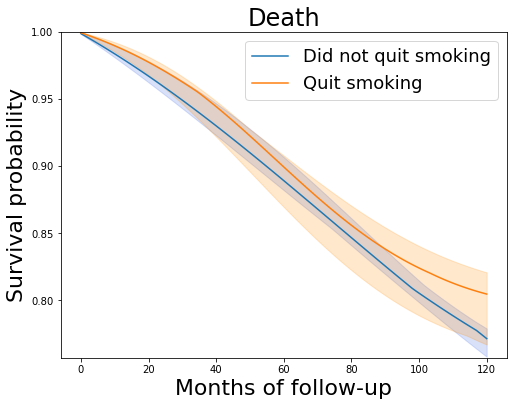

In [10]:
survival_analysis_OW = Survival_Analysis(data_df, outcome_df, outcome_time_col, 'censoring', 'Death', 
                                         id_col, index_time_col, TX_col, TX_labels_dict, TX_colors, followup_end_time, 
                                         followup_max_time_from_index, months_bins, ps_df, 'pscore', ps_cols, 'OW', n_bootstraps=5)

survival_analysis_OW.estimate_survival(method='OW')
survival_analysis_OW.plot_survival()
survival_analysis_OW.survival_difference(followup_max_time_from_index_binned - 1)
survival_analysis_OW.odds_ratio_at_max_follwup()

## Fit and plot model using Standardization

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:24<00:18, 18.42s/it]C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:02<00:00, 24.59s/it]


Difference in survival probability at time 120: -0.049% (-3.904, 1.973)
 Incident rate: Did not quit smoking: 216, Quit smoking: 102
Odds ratio at max followup: 0.268 (0.202, 0.520)


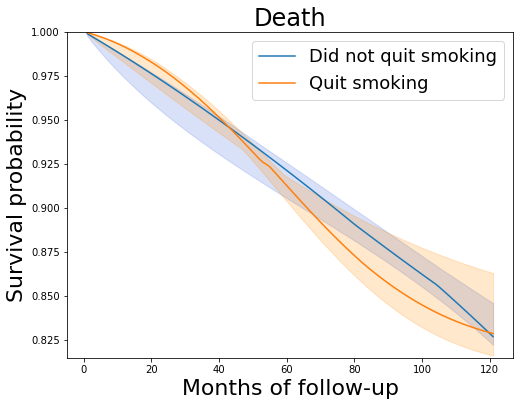

In [11]:
model = LogisticRegression(penalty='none', solver='lbfgs', max_iter=1000)

NUMERIC_FEATURES = ['age', 'age_sqr', 'wt71', 'wt71_sqr','smokeintensity', 'smokeintensity_sqr', 'smokeyrs', 'smokeyrs_sqr']
numeric_transformer = Pipeline(steps=[('std', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, NUMERIC_FEATURES)], remainder='passthrough')

survival_analysis.estimate_survival('STANDARDIZE', model, preprocessor, NUMERIC_FEATURES)
survival_analysis.plot_survival()
survival_analysis.survival_difference(followup_max_time_from_index_binned - 1)
survival_analysis.odds_ratio_at_max_follwup()